In [13]:
import nmresearch as nmr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import time
import pickle
import rustworkx as rx

In [2]:
# decent color schemes for plots and such

colors = [
    "#1984c5",
    "#22a7f0",
    "#63bff0",
    "#a7d5ed",
    "#e2e2e2",
    "#e1a692",
    "#de6e56",
    "#e14b31",
    "#c23728",
]

colors_single = [
    "#fff5eb",
    "#fee6ce",
    "#fdd0a2",
    "#fdae6b",
    "#fd8d3c",
    "#f16913",
    "#d94801",
    "#a63603",
    "#7f2704",
]
colors_single.reverse()
zcorr_str = r"$\langle$ $\hat{S}_z (nT)$ $\hat{S}_z$ $\rangle$"
xcorr_str = r"$\langle$ $\hat{S}_x (nT)$ $\hat{S}_x$ $\rangle$"
mucorr_str = r"$\langle$ $\hat{S}_\mu (nT)$ $\hat{S}_\mu$ $\rangle$"
zcorr_loc_str = r"$\langle$ $\hat{S}_z^{(0)} (nT)$ $\hat{S}_z^{(0)}$ $\rangle$"

In [3]:
plt.rcParams.update({"font.size": 14})
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

In [4]:
def get_perc_data(filename):
    filename = "data/" + filename
    try:
        return pickle.load(open(filename, "rb"))
    except FileNotFoundError:
        return None


def expected_nodes(r0):
    return 4 * r0**3 + 6 * r0**2 + 3 * r0 + 1

In [100]:
fcc = nmr.FccGraph()
q_calc = nmr.QuantumGraph(fcc)
G = fcc.load_graph(dim=20, layers=1)

In [101]:
G.num_nodes()

34461

In [102]:
np.max([np.linalg.norm(vec) for vec in G.nodes()])

34.64101615137755

In [103]:
comps = rx.connected_components(G)
distro = [len(comp) for comp in comps]
largest_local = np.max(distro)
ll_idx = np.argmax(distro)
largest_subgraph_idxs = list(comps[ll_idx])

In [ ]:
# Find the node index with data payload [0, 0, 0]
target_payload = [0, 0, 0]
node_index = None
for idx in largest_subgraph_idxs:
    if np.all(G.get_node_data(idx) == target_payload):
        node_index = idx
        break
node_index

In [119]:
n_walkers = 5000
walker_indices = np.array([4630 for _ in range(n_walkers)])

In [120]:
x0 = np.array([G.get_node_data(idx) for idx in walker_indices])

In [121]:
steps = 500
distances = np.zeros((n_walkers, steps+1))
for i in range(steps):
    for j in range(n_walkers):
        neighbors = G.neighbors(walker_indices[j])
        if len(neighbors) == 0:
            continue
        walker_indices[j] = np.random.choice(neighbors)
        x1 = G.get_node_data(walker_indices[j])
        distances[j, i+1] = np.linalg.norm(x1 - x0[j])

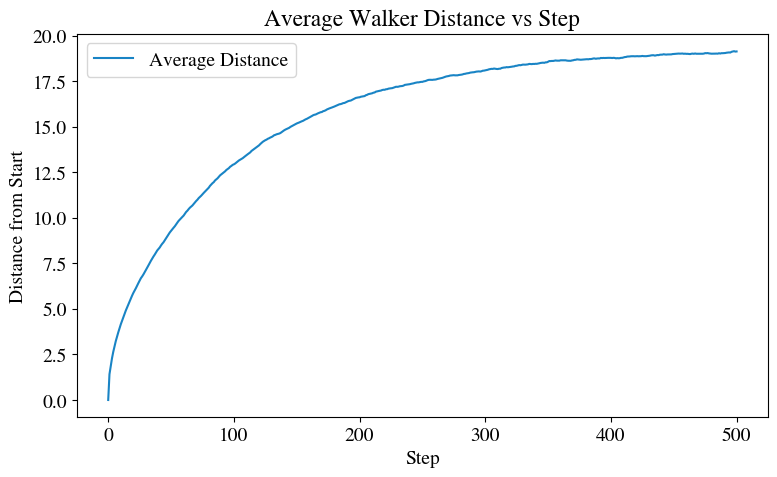

In [122]:
avg_distances = np.mean(distances, axis=0)
plt.figure(figsize=(8, 5))
plt.plot(avg_distances, color=colors[0], label="Average Distance")
plt.xlabel("Step")
plt.ylabel("Distance from Start")
plt.title("Average Walker Distance vs Step")
plt.legend()
plt.tight_layout()
plt.show()

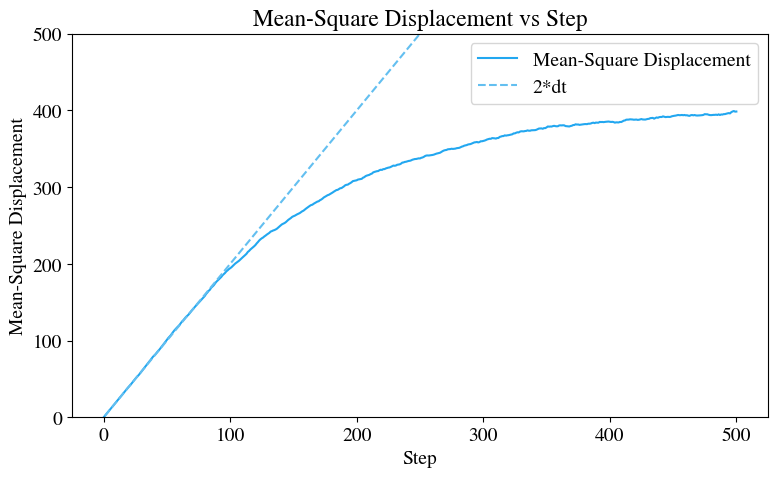

In [139]:
from scipy.stats import linregress

# Mean-square displacement (MSD)
msd = np.mean(distances**2, axis=0)

# Fit MSD to a line (ignore step 0 to avoid the trivial zero)
steps_arr = np.arange(1, steps+1)

# Plot MSD and linear fit
plt.figure(figsize=(8, 5))
plt.plot(msd, color=colors[1], label="Mean-Square Displacement")
plt.plot(steps_arr, 2*steps_arr, '--', color=colors[2], label=f"2*dt")
plt.xlabel("Step")
plt.ylabel("Mean-Square Displacement")
plt.title("Mean-Square Displacement vs Step")
plt.legend()
plt.ylim(0,500)
plt.tight_layout()
plt.show()

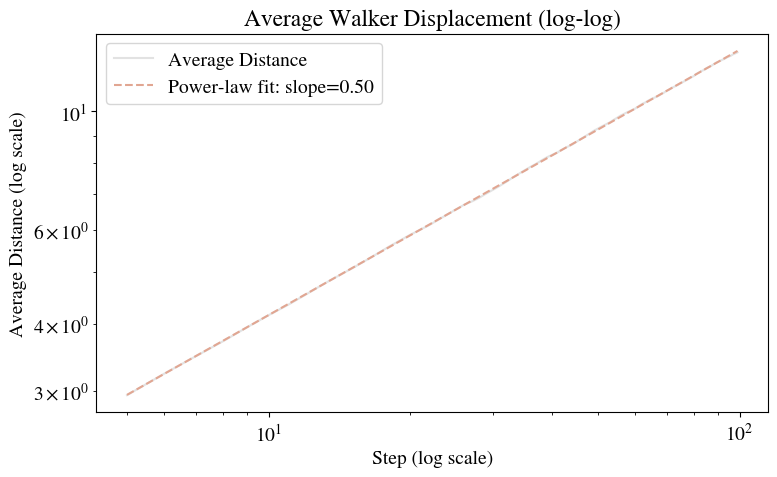

In [133]:
from scipy.stats import linregress

# Exclude step 0 to avoid log(0)
end = 100
start = 5
steps_nonzero = np.arange(start, end)
avg_dist_nonzero = avg_distances[start:end]

# Take logs
log_steps = np.log10(steps_nonzero)
log_avg_dist = np.log10(avg_dist_nonzero)

# Linear fit in log-log space
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = linregress(log_steps, log_avg_dist)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps_nonzero, avg_dist_nonzero, color=colors[4], label="Average Distance")
plt.plot(steps_nonzero, 10**(intercept_log + slope_log * log_steps), '--', color=colors[5],
         label=f"Power-law fit: slope={slope_log:.2f}")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Step (log scale)")
plt.ylabel("Average Distance (log scale)")
plt.title("Average Walker Displacement (log-log)")
plt.legend()
plt.tight_layout()
plt.show()